In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import cvlib as cv
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [3]:
#clean_data = pd.read_csv("../data/data1/clean_data_full.csv")
clean_data = pd.read_csv("../data/data1/clean_data_short.csv")

In [4]:
clean_data = clean_data.drop(columns = ['Unnamed: 0'])

In [5]:
clean_data

,age,gender,x,y,dx,dy,img_path
0,5,0,1912,905,1224,1224,../data/data1/faces/30601258@N03/coarse_tilt_a...
1,4,1,101,56,740,740,../data/data1/faces/30601258@N03/coarse_tilt_a...
2,4,0,693,247,720,720,../data/data1/faces/30601258@N03/coarse_tilt_a...
3,4,0,1039,1432,624,625,../data/data1/faces/30601258@N03/coarse_tilt_a...
4,4,1,223,58,780,781,../data/data1/faces/30601258@N03/coarse_tilt_a...
...,...,...,...,...,...,...,...
9806,6,1,913,621,189,187,../data/data1/faces/101515718@N03/coarse_tilt_...
9807,4,1,0,404,741,769,../data/data1/faces/101515718@N03/coarse_tilt_...
9808,4,0,718,748,492,492,../data/data1/faces/101515718@N03/coarse_tilt_...
9809,4,0,950,0,692,687,../data/data1/faces/101515718@N03/coarse_tilt_...


## Convert images to array 

In [5]:
X = clean_data[['img_path']]
y = clean_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((128, 128))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    
    image = image.resize((128, 128))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train data shape (6867, 1)
Test data shape (2944, 1)
Train images shape (6867, 128, 128, 3)
Test images shape (2944, 128, 128, 3)


## Gender model 

In [6]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16, (3,3),padding='same', activation='relu', input_shape=(128, 128, 3)),
    
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3),padding='same', activation='relu'),
    
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same',activation='relu'),
    
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same',activation='relu'),
    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

2021-11-16 11:40:23.476976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 11:40:23.481240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 11:40:23.481670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 11:40:23.482536: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_images, y_train, batch_size=32, epochs=25, validation_data=(test_images, y_test), callbacks=[callback])

print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

model.save('../data/gender_model_16_2021.h5')

Epoch 1/25


/home/pj/miniconda3/envs/cv/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2021-11-16 11:40:46.595802: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2021-11-16 11:40:46.975161: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


215/215 [==============================] - ETA: 0s - loss: 4.7705 - accuracy: 0.6218

/home/pj/miniconda3/envs/cv/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


215/215 [==============================] - 12s 45ms/step - loss: 4.7705 - accuracy: 0.6218 - val_loss: 0.6264 - val_accuracy: 0.6637
Epoch 2/25
215/215 [==============================] - 9s 41ms/step - loss: 0.5645 - accuracy: 0.7112 - val_loss: 0.5225 - val_accuracy: 0.7337
Epoch 3/25
215/215 [==============================] - 9s 41ms/step - loss: 0.4816 - accuracy: 0.7639 - val_loss: 0.6024 - val_accuracy: 0.6899
Epoch 4/25
215/215 [==============================] - 9s 41ms/step - loss: 0.4012 - accuracy: 0.8161 - val_loss: 0.4934 - val_accuracy: 0.7711
Epoch 5/25
215/215 [==============================] - 9s 42ms/step - loss: 0.3325 - accuracy: 0.8525 - val_loss: 0.5040 - val_accuracy: 0.7666
Epoch 6/25
215/215 [==============================] - 9s 43ms/step - loss: 0.2511 - accuracy: 0.8914 - val_loss: 0.4545 - val_accuracy: 0.7874
Epoch 7/25
215/215 [==============================] - 9s 42ms/step - loss: 0.1638 - accuracy: 0.9317 - val_loss: 0.6078 - val_accuracy: 0.7928
Epoch 8/2

## losses 

In [8]:
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print(test_acc)

92/92 - 1s - loss: 1.1608 - accuracy: 0.7918 - 818ms/epoch - 9ms/step
0.7917798757553101


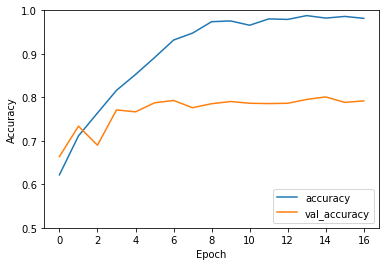

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

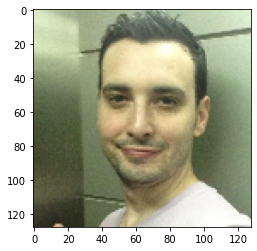

In [14]:
image_path = X_test.img_path[107]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (128, 128)) / 255.0
plt.imshow(image)
plt.show()

In [17]:
X_test.img_path[107]

'../data/data1/faces/30601258@N03/coarse_tilt_aligned_face.2.10152857645_329d2ef8cb_o.jpg'

In [18]:
image = np.expand_dims(image, 0)
prediction = model.predict(image)

In [19]:
prediction 

array([[1.000000e+00, 2.249237e-18]], dtype=float32)

In [20]:
index = np.argmax(prediction)
decoding = {0:'f', 1:'m'}
print('[+] prediction is :', decoding[index]) 


[+] prediction is : f


In [21]:
predictions = model.predict(test_images)

In [22]:
predictions 

array([[7.5768930e-01, 2.4231066e-01],
       [3.7756456e-15, 1.0000000e+00],
       [2.6489824e-13, 1.0000000e+00],
       ...,
       [2.1510189e-07, 9.9999976e-01],
       [8.8514369e-08, 9.9999988e-01],
       [9.1955917e-05, 9.9990809e-01]], dtype=float32)

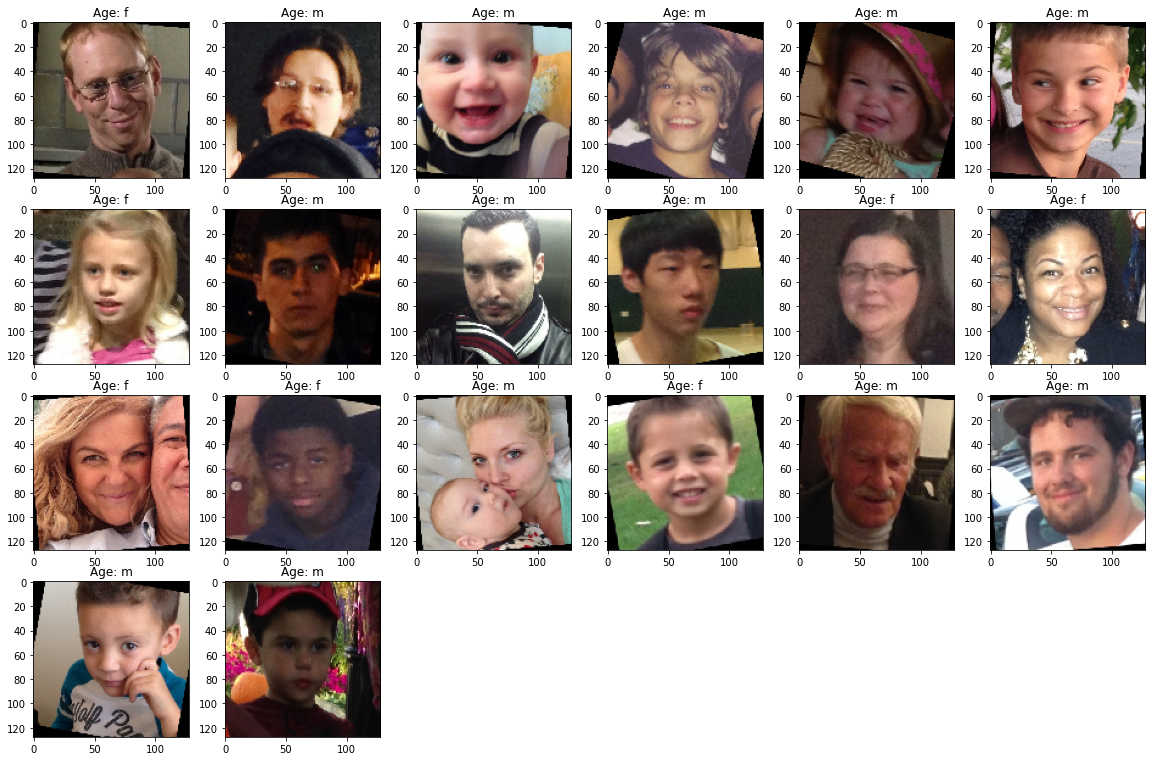

In [24]:
plt.figure(figsize=(20,20))
for row in range(20):
    plt.subplot(6,6,row+1)
    index = np.argmax(predictions[row])
    decoding = {0:'f', 1:'m'}
    plt.title('Age: ' + decoding[index] )
    plt.imshow(test_images[row])